---------------------------------------
<hr style="border:2px solid black"> </hr>

# Speech Coding Strategies for Cochlear Implants

---------------------------------------
<hr style="border:2px solid black"> </hr>

This aim of this notebook is to present some important speech coding strategies for cochlear implants. These techniques are used to transform audio signals captured by microphones into electric signals stimulating the auditory nerve in the cochlear. 

**Targets:**

- Conversion of acoustic signal into respective electro-neural stimulus
- Reduction of redundance

**Challenges**:

- Limitation of channels (frequency resolution)
- Refractory period (1 kHz, time resolution)
- Crosstalk between electrodes (cochlea 3D)
- Current of electrodes can sum up

**Important principles:**

- Tonotopic organization of the cochlea
- Pulsatile coding better than analog stimuli
- No direct current
- Impedance changes: constant current sources
- Electric charge per pulse = Loudness
- Loudness is a non-linear function
- Mapping necessary: 120dB - 12dB
- Stimulation rate influences dynamics
- Trade-off between comprehensibility and convenience

In [1]:
using PyPlot
using PyCall
@pyimport matplotlib.gridspec as gridspec
using WAV
using DSP
using FFTW

In [2]:
include("src/utils.jl")
include("src/plotting.jl");

For this notebook an audio file from this [database](http://www.ifp.illinois.edu/~haotang2/emodb.html) was used for further processing. The sampling rate is 44.1 kHz. The sentence is part of **[Harvard Sentences](http://www.cs.columbia.edu/~hgs/audio/harvard.html)** which are phonetically balanced and semantically neutral. The sentence is spoken by an actress with a happy emotion and says 

"*The birch canoe slid on the smooth planks.*"

![title](img/emodb_happy.jpg)

In [3]:
path = "./data/"
file = "emodb_happy.wav"
wav_file = wavread(string(path,file)) 
audio_orig = wav_file[1][:,1]        # just one channel if stereo
Fs = wav_file[2]                     # sampling rate

N_signal = length(audio_orig)        # length of signal vector
time = (0:N_signal-1)/Fs;            # create time vector

---------------------------------------

### Pre-emphasis

First, a pre-emphasis filter is applied to the speech signal in order to attenuate lower frequencies and thus balance the frequency spectrum. High frequency components usually have lower magnitudes.

The filter is implemented as a first order high-pass filter of the form 

$$y[n] = x[n] - \alpha x[n-1]$$

with $\alpha=0.95$.

The result of the pre-emphasis filter is shown both in time and frequency domain. In the spectrogram it is clearly visible how the low frequency components are attenuated. 

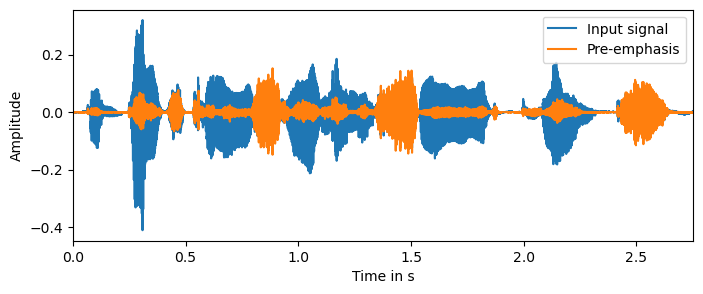

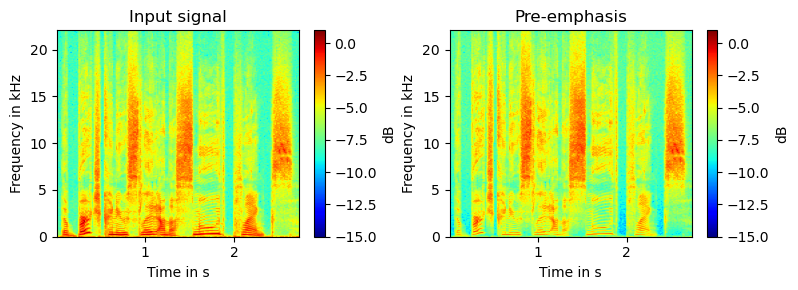

In [4]:
# perform pre-emphasis on audio signal
audio = pre_emph(audio_orig)

#-------------------------------------------------------------------------------
# Plotting

figure(figsize=(8,3))
plot_audio(time,audio_orig)
plot_audio(time,audio)
legend(["Input signal", "Pre-emphasis"])

figure(figsize=(8,3))
subplot(1,2,1)
plot_spectrogram(audio_orig, Fs)
title("Input signal")
subplot(1,2,2)
plot_spectrogram(audio, Fs)
title("Pre-emphasis")
tight_layout()
#-------------------------------------------------------------------------------

--------------------------------------

<hr style="border:2px solid black"> </hr>

## House/3M Single Channel CI [fretz+1985]

![title](img/House_3M_Single_Channel_CI.png)

- Analog stimulation includes 16 kHz carrier
- Transcutaneous link through induction coil
- Small dynamic range on nerve lets output saturate/distort
- Majority of patients did not obtain open-set speech recognition
- Exceptional patients achieved 20-40% consonant recognition [danhauer+1990]

---------------------------------------
<hr style="border:2px solid black"> </hr>

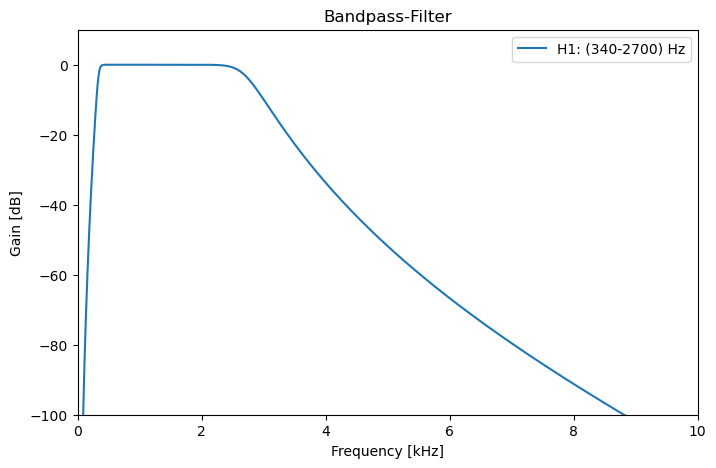

In [5]:
# Design of the bandpass filter: Butterworth filter 
prototype = Butterworth(8);                 # filter order
responsetype = Bandpass(340,2700; fs=Fs);   # cut-off frequencies
cochlear_filter = digitalfilter(responsetype, prototype);

w = 0:0.001:pi                 # frequency vector
H = freqz(cochlear_filter, w)  # filter response

# Plot magnitude response

figure(figsize=(8,5))
plot(Fs/2*w/pi/1000, 20*log10.(abs.(H)))
xlabel("Frequency [kHz]")
ylabel("Gain [dB]")
xlim([0,10])
ylim([-100,10])
title("Bandpass-Filter")
legend(["H1: (340-2700) Hz"])

# Filtering the input signal
audio_filt = filt(cochlear_filter, audio);

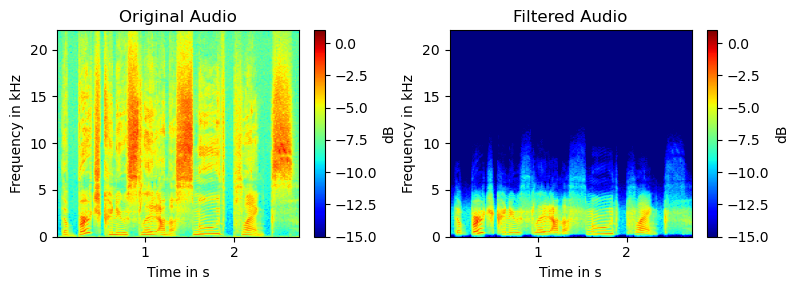

In [6]:
figure(figsize=(8,3))
subplot(1,2,1)
plot_spectrogram(audio, Fs)
title("Original Audio")

subplot(1,2,2)
plot_spectrogram(audio_filt, Fs)
title("Filtered Audio")
tight_layout();

In [7]:
# Create the carrier signal 

f = 16e3
if f > Fs/2
    print("Select a sound file with higher sampling rate.")
end
    
f_carr = sin.(2*pi*f.*time)
f_electrode = f_carr .* audio_filt;

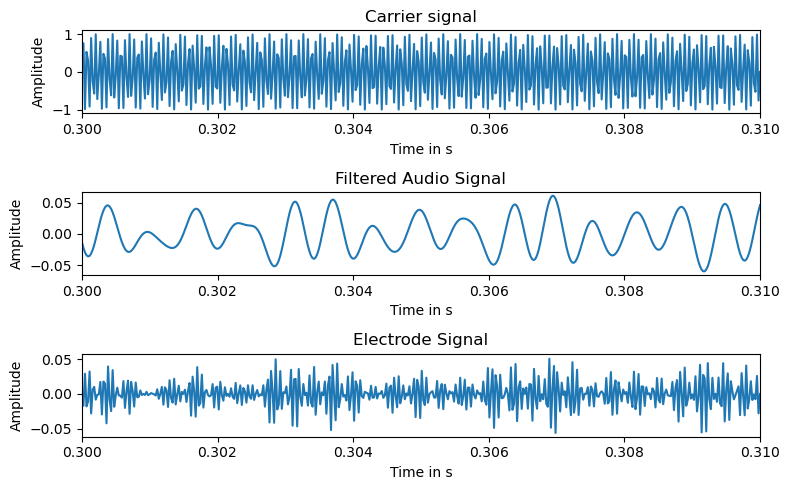

In [8]:
figure(figsize=(8,5))

subplot(3,1,1)
plot_audio(time,f_carr)
xlim([0.3,0.31])
title("Carrier signal")

subplot(3,1,2)
plot_audio(time,audio_filt)
xlim([0.3,0.31])
title("Filtered Audio Signal")

subplot(3,1,3)
plot_audio(time, f_electrode)
xlim([0.3,0.31])
title("Electrode Signal")

tight_layout()

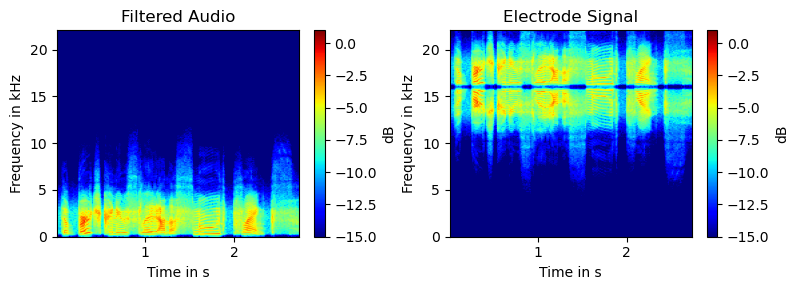

In [9]:
figure(figsize=(8,3))
subplot(1,2,1)
plot_spectrogram(audio_filt, Fs)
title("Filtered Audio")

subplot(1,2,2)
plot_spectrogram(f_electrode, Fs)
title("Electrode Signal")
tight_layout();

---------------------------------------
<hr style="border:2px solid black"> </hr>

## Multi-channel Analog CI

![title](img/Multi_channel_Analog_CI.png)

- **Problem:** Channel overlap – current spread in cochlea

---------------------------------------
<hr style="border:2px solid black"> </hr>

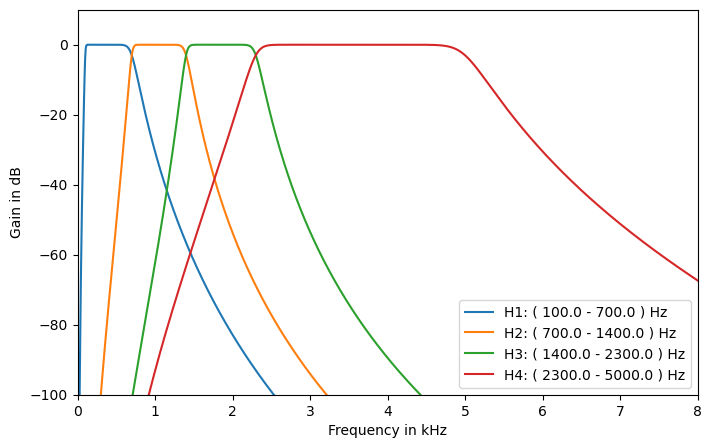

In [10]:
# Define the cut-off-frequencies for the bandbass filters
freq_passband = [[0.1,0.7]   [0.7,1.4]    [1.4,2.3]   [2.3, 5]]*1e3

filter_output = zeros(4,length(audio))
legend_str = Array{Union{Nothing, String}}(nothing, 4)
w = 0:0.001:pi 

figure(figsize=(8,5))

for i in 1:4
    responsetype = Bandpass(freq_passband[1,i], freq_passband[2,i]; fs=Fs);
    prototype = Butterworth(8);
    cochlear_filter = digitalfilter(responsetype, prototype);
    
    H = freqz(cochlear_filter, w)
    plot(Fs/2*w/pi/1000, 20*log10.(abs.(H)))
    xlim([0,8])
    ylim([-100,10])
    xlabel("Frequency in kHz")
    ylabel("Gain in dB")
    filter_output[i,:] = filt(cochlear_filter, audio);
    legend_str[i] = string("H",i,": ","( ",freq_passband[1,i], " - ",
                                                    freq_passband[2,i]," ) Hz")
end
legend(legend_str);

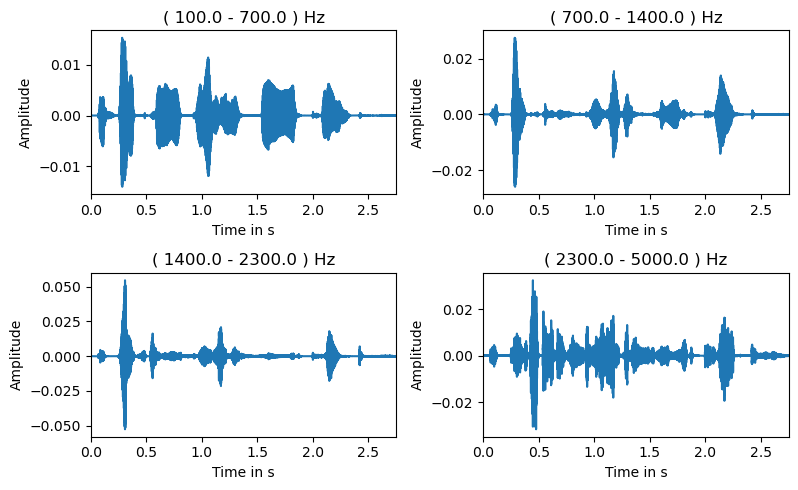

In [11]:
figure(figsize=(8,5))

for i in 1:4
    subplot(2,2,i)
    plot_audio(time,filter_output[i,:])
    title(string("( ",freq_passband[1,i]," - ",freq_passband[2,i]," ) Hz"))
end
tight_layout()

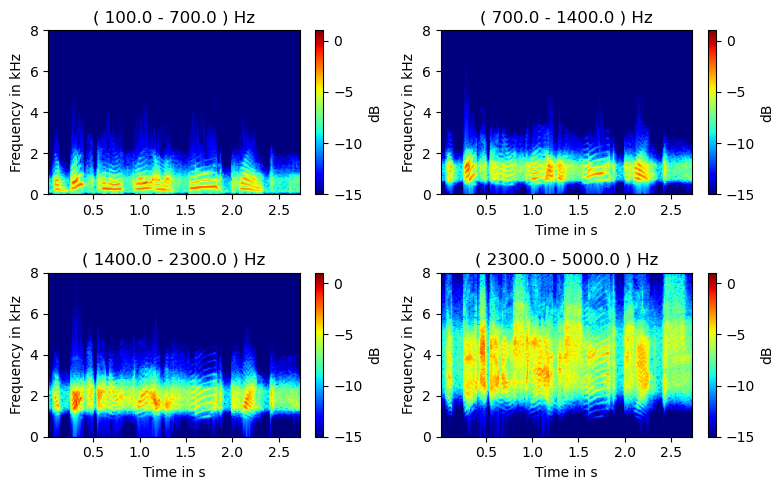

In [12]:
figure(figsize=(8,5))

for i in 1:4
    subplot(2,2,i)
    plot_spectrogram(filter_output[i,:], Fs)
    title(string("( ",freq_passband[1,i]," - ",freq_passband[2,i]," ) Hz"))
    ylim([0, 8])
end
tight_layout()

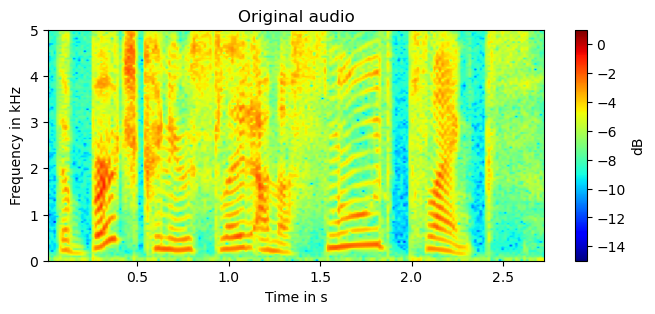

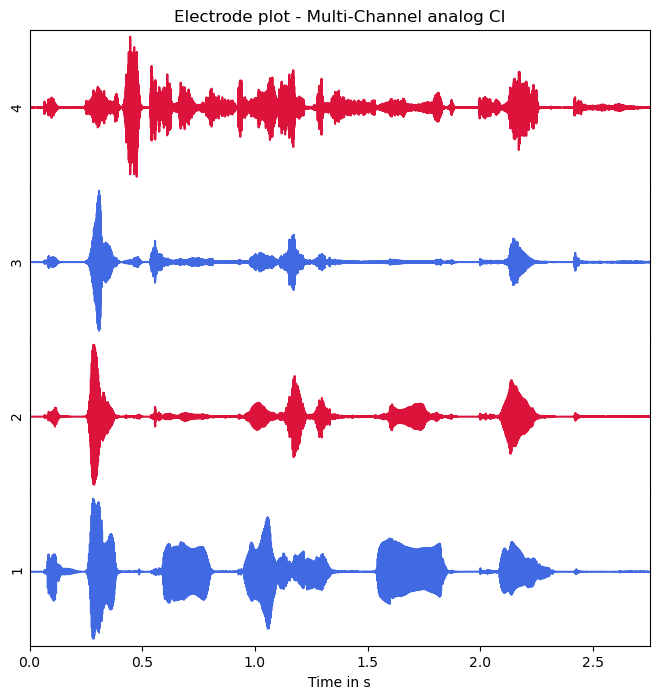

In [13]:
figure(figsize=(8,3))
plot_spectrogram(audio, Fs)
ylim([0,5])
title("Original audio")

plot_electrode(4,time,filter_output,
                               title="Electrode plot - Multi-Channel analog CI")
electrode_plot_MCCI = filter_output;

---------------------------------------
<hr style="border:2px solid black"> </hr>

## Feature Extraction Strategy F0-F2

![title](img/feature_f0_f2.png)

- 22 electrode array, only 1 electrode stimulated
- F0 coded in rate and formant F2 in place and amplitude
- Unvoiced intervals: quasi-random stimulation 100 pulses/s
- Clearly improved understanding of words
- Problems with consonants

---------------------------------------
<hr style="border:2px solid black"> </hr>

Design of the first two filters: 270 Hz LPF, 1-4 kHz BPF

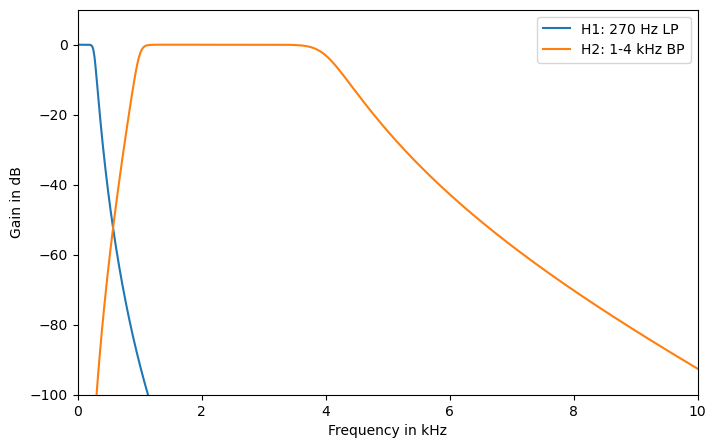

In [14]:
filter_output = zeros(2,length(audio))
w = 0:0.001:pi 

prototype = Butterworth(8);

responsetype = Lowpass(270; fs=Fs);
cochlear_filter = digitalfilter(responsetype, prototype);
H_low = freqz(cochlear_filter, w)
filter_output[1,:] = filt(cochlear_filter, audio);

responsetype = Bandpass(1e3, 4e3; fs=Fs);
cochlear_filter = digitalfilter(responsetype, prototype);
H_bp = freqz(cochlear_filter, w)
filter_output[2,:] = filt(cochlear_filter, audio);

figure(figsize=(8,5))
plot(Fs/2*w/pi/1000, 20*log10.(abs.(H_low)))
plot(Fs/2*w/pi/1000, 20*log10.(abs.(H_bp)))
xlim([0,10])
ylim([-100,10])
xlabel("Frequency in kHz")
ylabel("Gain in dB")
legend(("H1: 270 Hz LP","H2: 1-4 kHz BP"));

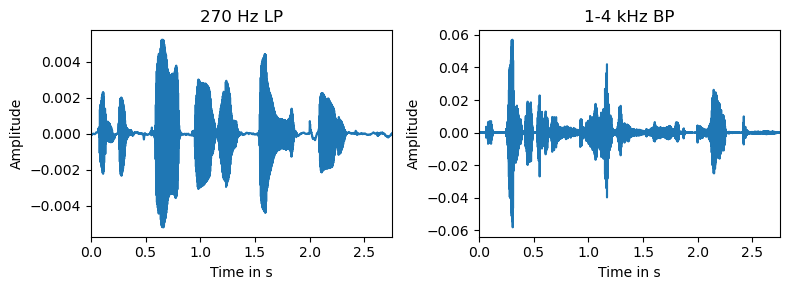

In [15]:
figure(figsize=(8,3))
title_str = ["270 Hz LP", "1-4 kHz BP"]

for i in 1:2
    subplot(1,2,i)
    plot_audio(time,filter_output[i,:])
    title(title_str[i])
end

tight_layout()

Design of the 35 Hz LPF to obtain envelope after rectifying the signal:

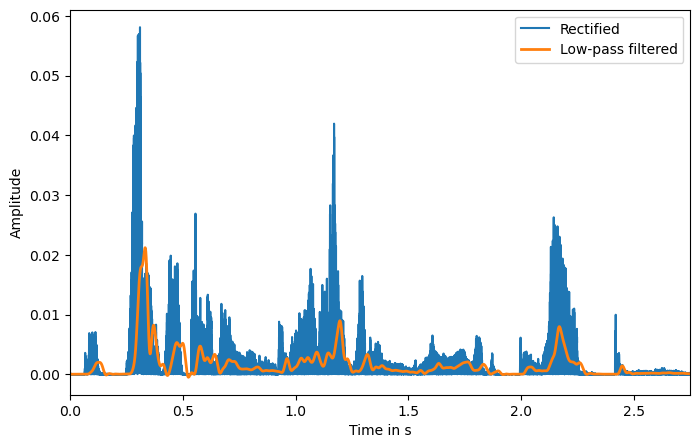

In [16]:
prototype = Butterworth(8);
responsetype = Lowpass(35; fs=Fs);
lp_filter = digitalfilter(responsetype, prototype);
rect_audio = abs.(filter_output[2,:])
rect_low = filt(lp_filter, rect_audio);

figure(figsize=(8,5))
plot_audio(time,rect_audio)
plot(time,rect_low,lw=2)
legend(["Rectified", "Low-pass filtered"]);

Partition the speech signal into smaller, overlapping frames:
Here, a **frame size** of **25ms** and a **stride** of **10ms** (**overlap** of **15ms**) was chosen. This frame length allows to capture data from one phoneme and it includes approximately two periods of the fundamental frequency during voiced speech.

Then, the zero-crossing rate in each frame is used to estimate the fundamental frequency F0 (coded in pulse rate) and the second formant frequency (coded in place).

In [17]:
signal_frames_F0 = generate_frames(filter_output[1,:],Fs);
signal_frames_F2 = generate_frames(filter_output[2,:],Fs);
frame_length = size(signal_frames_F0)[2]
number_frames = size(signal_frames_F0)[1]
time_frames = collect( range(0,last(time),length=number_frames) )

F0_ZC = zeros((number_frames,1))
F2_ZC = zeros((number_frames,1))

for (idx,i) in enumerate(1:number_frames)
    F0_ZC[idx] = freq_est_ZC(signal_frames_F0[i,:],Fs)
    F2_ZC[idx] = freq_est_ZC(signal_frames_F2[i,:],Fs)
end

During unvoiced intervals, a pulse rate of 100 pulses/s is used. The easiest way to distinguish between voiced and unvoiced speech is to look at the zero-crossing rate. When the zero-crossing rate exceeds a certain upper threshold, no dominant low-frequency component can be determined and the speech segment is classified as unvoiced.

In [18]:
zcrThreshold = 300
F0_ZC[F0_ZC .> zcrThreshold] .= 100;

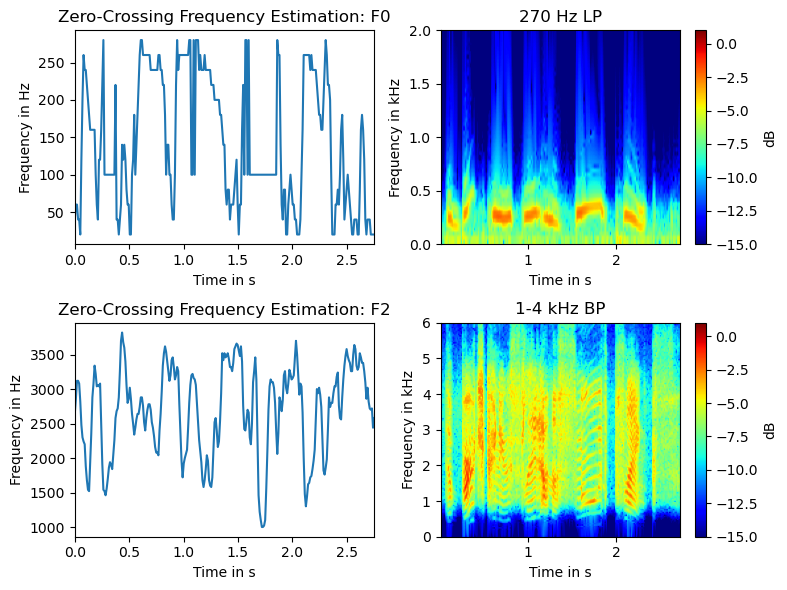

In [19]:
#-------------------------------------------------------------------------------
# Plots
#-------------------------------------------------------------------------------

figure(figsize=(8,6))

subplot(2,2,1)
plot_audio(time_frames,F0_ZC)
ylabel("Frequency in Hz")
title("Zero-Crossing Frequency Estimation: F0")
subplot(2,2,2)
plot_spectrogram(filter_output[1,:], Fs)
ylim([0,2])
title(title_str[1])
subplot(2,2,3)
plot_audio(time_frames,F2_ZC)
ylabel("Frequency in Hz")
title("Zero-Crossing Frequency Estimation: F2")
subplot(2,2,4)
plot_spectrogram(filter_output[2,:], Fs)
ylim([0,6])
title(title_str[2])

tight_layout()

Then, the signals stimulating the electrodes are generated with biphasic pulses. 

- Pulse rate: determined by F0
- Active electrode: determined by F2
- Amplitude: determined by envelope

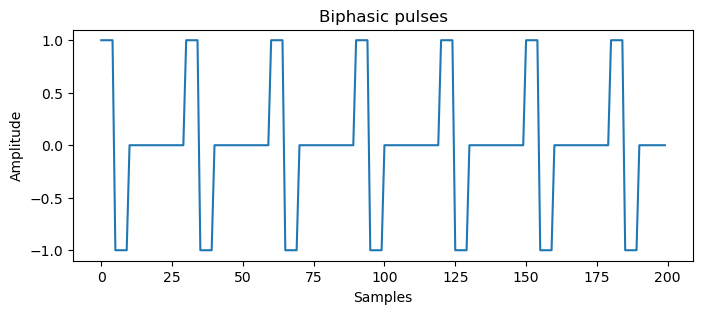

In [20]:
y_pulse = biphasic_pulse(200,10,30)

figure(figsize=(8,3))
plot(y_pulse)
xlabel("Samples") 
ylabel("Amplitude") 
title("Biphasic pulses");

In [21]:
N_electrodes = 22

(electrode_signal, electrodes, pulses, freq_spacing) =
pulse_generation(Fs,F0_ZC,F2_ZC,rect_low,N_electrodes);

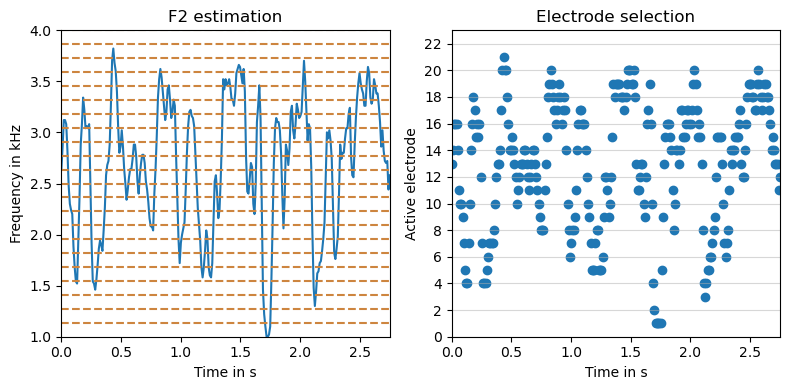

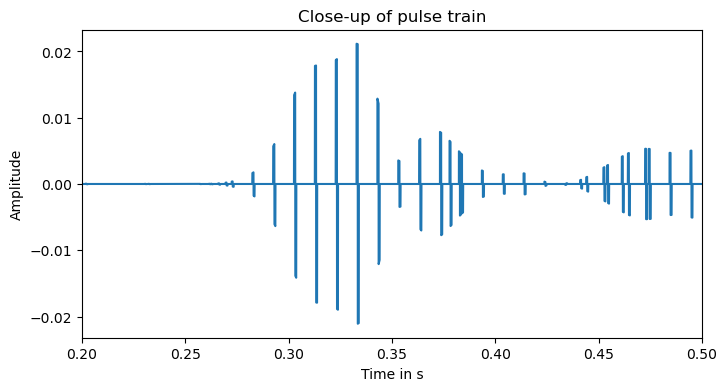

In [22]:
#-------------------------------------------------------------------------------
# Plots
#-------------------------------------------------------------------------------

figure(figsize=(8,4))

subplot(1,2,1)
plot_audio(time_frames,F2_ZC ./ 1000)
[ plt.axhline(y=hline,color="peru",linestyle="--") 
                                                for hline in freq_spacing./1000]
ylim([1,4])
ylabel("Frequency in kHz")
title("F2 estimation")

subplot(1,2,2)
scatter(time_frames,electrodes)
xlabel("Time in s")
ylabel("Active electrode")
xlim([0,last(time)])
ylim([0,N_electrodes+1])
yticks(collect(0:2:N_electrodes))
grid("minor",axis="y",alpha=0.5)
title("Electrode selection")

tight_layout()

figure(figsize=(8,4))
plot_audio(time,pulses)
title("Close-up of pulse train")
xlim([0.2,0.5]);

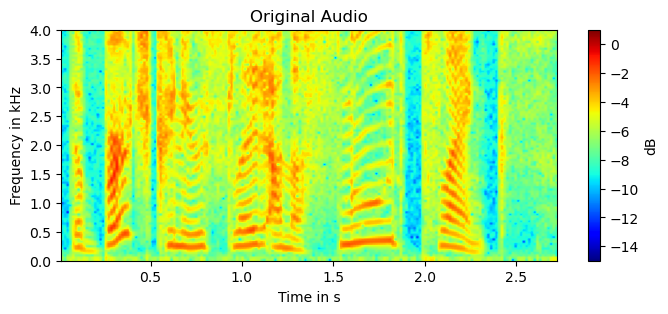

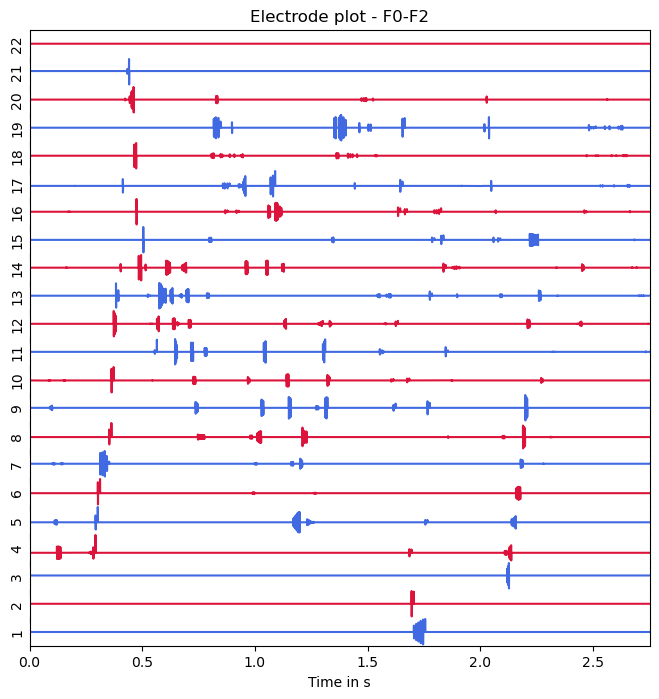

In [23]:
figure(figsize=(8,3))
plot_spectrogram(audio, Fs)
ylim([0,4])
title("Original Audio")

#-------------------------------------------------------------------------------
# Electrode plot

plot_electrode(N_electrodes,time,electrode_signal,
    title="Electrode plot - F0-F2")
electrode_plot_F0F2 = electrode_signal;

---------------------------------------
<hr style="border:2px solid black"> </hr>

## Feature Extraction Strategy F0-F1-F2

![title](img/feature_f0_f1_f2.png)

- Improvement of vowel, but not consonant recognition
- Word scores from 30% (F0/F2) to 63% [dowell+1987]

---------------------------------------
<hr style="border:2px solid black"> </hr>

Design of the first three filters: 270 Hz LPF, 0.3-1 kHz BPF, 1-4 kHz BPF

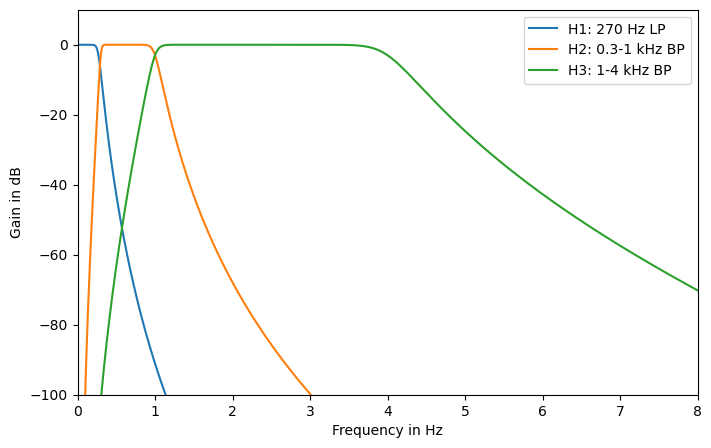

In [24]:
filter_output = zeros(3,length(audio))
w = 0:0.001:pi 

prototype = Butterworth(8);

responsetype = Lowpass(270; fs=Fs);
cochlear_filter = digitalfilter(responsetype, prototype);
H_low = freqz(cochlear_filter, w)
filter_output[1,:] = filt(cochlear_filter, audio);

responsetype = Bandpass(0.3e3, 1e3; fs=Fs);
cochlear_filter = digitalfilter(responsetype, prototype);
H_bp_low = freqz(cochlear_filter, w)
filter_output[2,:] = filt(cochlear_filter, audio);

responsetype = Bandpass(1e3, 4e3; fs=Fs);
cochlear_filter = digitalfilter(responsetype, prototype);
H_bp_up = freqz(cochlear_filter, w)
filter_output[3,:] = filt(cochlear_filter, audio);

figure(figsize=(8,5))
plot(Fs/2*w/pi/1000, 20*log10.(abs.(H_low)))
plot(Fs/2*w/pi/1000, 20*log10.(abs.(H_bp_low)))
plot(Fs/2*w/pi/1000, 20*log10.(abs.(H_bp_up)))
xlim([0,8])
ylim([-100,10])
xlabel("Frequency in Hz")
ylabel("Gain in dB")
legend(("H1: 270 Hz LP","H2: 0.3-1 kHz BP","H3: 1-4 kHz BP"));

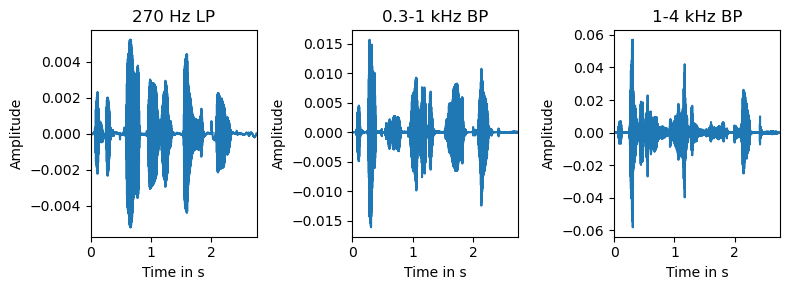

In [25]:
figure(figsize=(8,3))
title_str = ["270 Hz LP", "0.3-1 kHz BP", "1-4 kHz BP"]

for i in 1:3
    subplot(1,3,i)
    plot_audio(time,filter_output[i,:])
    title(title_str[i])
end

tight_layout()

Design of the 35 Hz LPF to obtain envelope after rectifying the signal:

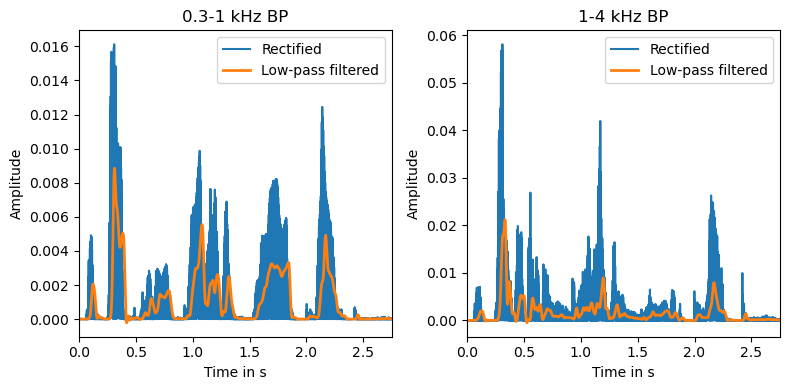

In [26]:
prototype = Butterworth(8)
responsetype = Lowpass(35; fs=Fs)
lp_filter = digitalfilter(responsetype, prototype)
rect_audio_bp_low = abs.(filter_output[2,:])
rect_audio_bp_high = abs.(filter_output[3,:])
rect_low_bp_low = filt(lp_filter, rect_audio_bp_low)
rect_low_bp_high = filt(lp_filter, rect_audio_bp_high);

figure(figsize=(8,4))
subplot(1,2,1)
plot_audio(time,rect_audio_bp_low)
plot(time,rect_low_bp_low,lw=2)
legend(["Rectified", "Low-pass filtered"])
title(title_str[2])
subplot(1,2,2)
plot_audio(time,rect_audio_bp_high)
plot(time,rect_low_bp_high,lw=2)
legend(["Rectified", "Low-pass filtered"])
title(title_str[3])
tight_layout()

Computation of zero-crossing rate in order to determine:
- fundamental frequency F0
- first formant frequency F1
- second formant frequency F2

In [27]:
signal_frames_F0 = generate_frames(filter_output[1,:],Fs);
signal_frames_F1 = generate_frames(filter_output[2,:],Fs);
signal_frames_F2 = generate_frames(filter_output[3,:],Fs);

frame_length = size(signal_frames_F0)[2]
number_frames = size(signal_frames_F0)[1]
time_frames = collect( range(0,last(time),length=number_frames) )

F0_ZC = zeros((number_frames,1))
F1_ZC = zeros((number_frames,1))
F2_ZC = zeros((number_frames,1))

for (idx,i) in enumerate(1:number_frames)
    F0_ZC[idx] = freq_est_ZC(signal_frames_F0[i,:],Fs)
    F1_ZC[idx] = freq_est_ZC(signal_frames_F1[i,:],Fs)
    F2_ZC[idx] = freq_est_ZC(signal_frames_F2[i,:],Fs)
end

Fixed pulse rate in unvoiced segments:

In [28]:
zcrThreshold = 300
F0_ZC[F0_ZC .> zcrThreshold] .= 100;

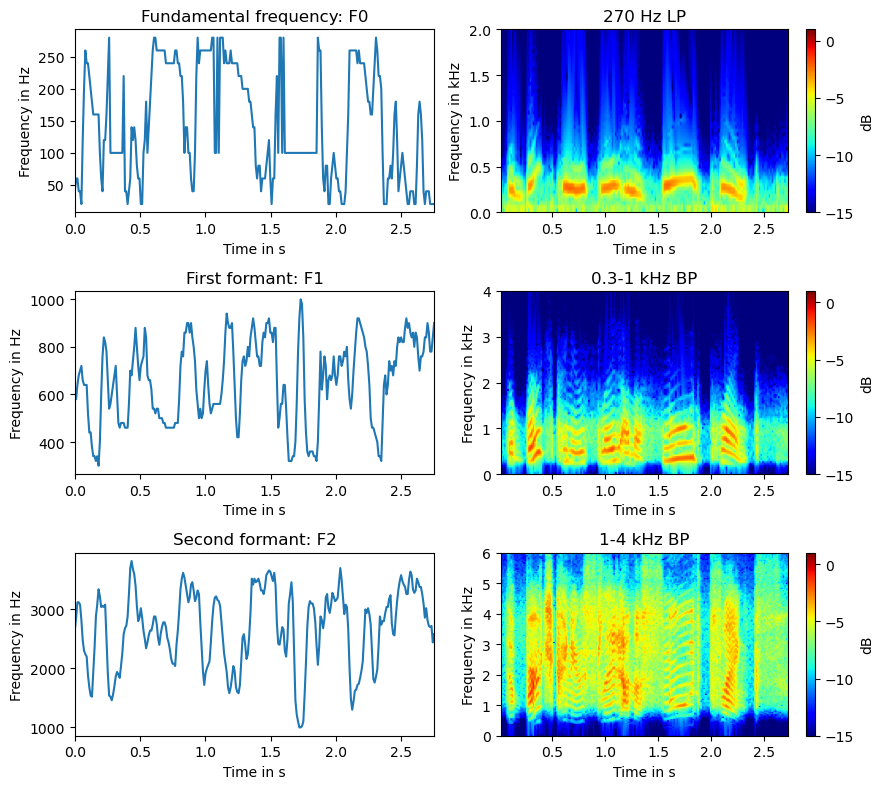

In [29]:
figure(figsize=(9,8))

subplot(3,2,1)
plot_audio(time_frames,F0_ZC)
ylabel("Frequency in Hz")
title("Fundamental frequency: F0")
subplot(3,2,3)
plot_audio(time_frames,F1_ZC)
ylabel("Frequency in Hz")
title("First formant: F1")
subplot(3,2,5)
plot_audio(time_frames,F2_ZC)
ylabel("Frequency in Hz")
title("Second formant: F2")

for i = 1:3
    subplot(3,2,i*2)
    plot_spectrogram(filter_output[i,:], Fs)
    title(title_str[i])
    ylim([0,i*2])
end
tight_layout()

Now, one of 5 apical electrodes and one of 15 basal electrodes is active during one frame. The active electrode is determined by F1 (apical electrodes) and F2 (basal electrodes).

In [30]:
N_electrodes_apical = 5
(electrode_signal_apical, electrodes_apical, pulses_apical, 
    freq_spacing_apical) = pulse_generation(Fs,F0_ZC,F1_ZC,rect_low_bp_low,
    N_electrodes_apical, f_low=300,f_high=maximum(F1_ZC))

N_electrodes_basal = 15
(electrode_signal_basal, electrodes_basal, pulses_basal, freq_spacing_basal) = 
    pulse_generation(Fs,F0_ZC,F2_ZC,rect_low_bp_high,N_electrodes_basal);

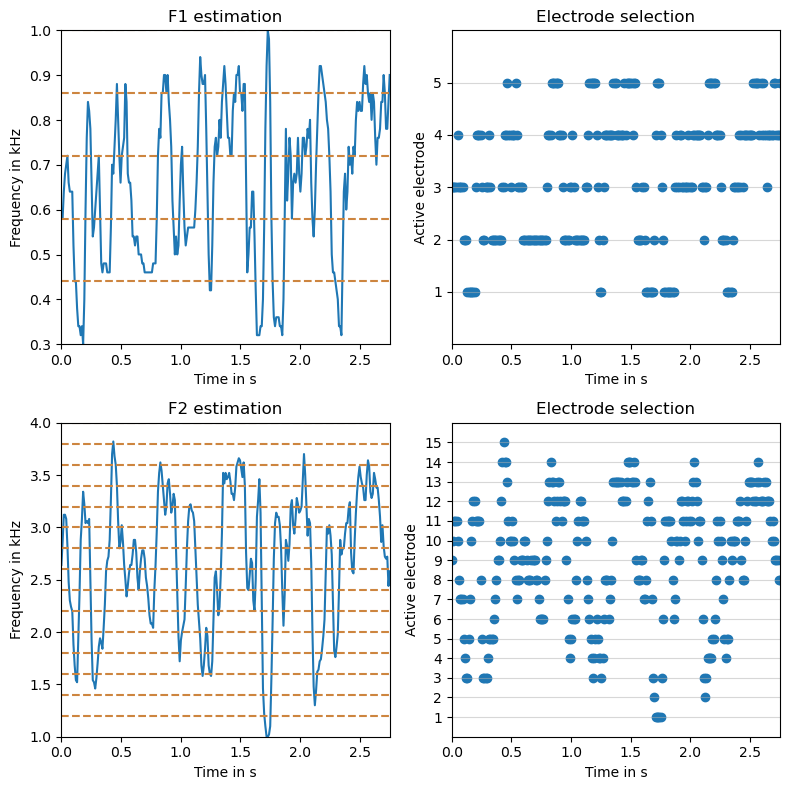

In [31]:
#-------------------------------------------------------------------------------
# Plots
#-------------------------------------------------------------------------------

figure(figsize=(8,8))

subplot(2,2,1)
plot_audio(time_frames,F1_ZC./1000)
[ plt.axhline(y=hline,color="peru",linestyle="--") 
                                         for hline in freq_spacing_apical./1000]
ylim([0.3,1])
ylabel("Frequency in kHz")
title("F1 estimation")

subplot(2,2,2)
scatter(time_frames,electrodes_apical)
xlabel("Time in s")
ylabel("Active electrode")
xlim([0,last(time)])
ylim([0,N_electrodes_apical+1])
yticks(collect(1:N_electrodes_apical))
grid("minor",axis="y",alpha=0.5)
title("Electrode selection")

subplot(2,2,3)
plot_audio(time_frames,F2_ZC./1000)
[ plt.axhline(y=hline,color="peru",linestyle="--") 
                                          for hline in freq_spacing_basal./1000]
ylim([1,4])
ylabel("Frequency in kHz")
title("F2 estimation")

subplot(2,2,4)
scatter(time_frames,electrodes_basal)
xlabel("Time in s")
ylabel("Active electrode")
xlim([0,last(time)])
ylim([0,N_electrodes_basal+1])
yticks(collect(1:N_electrodes_basal))
grid("minor",axis="y",alpha=0.5)
title("Electrode selection")

tight_layout()

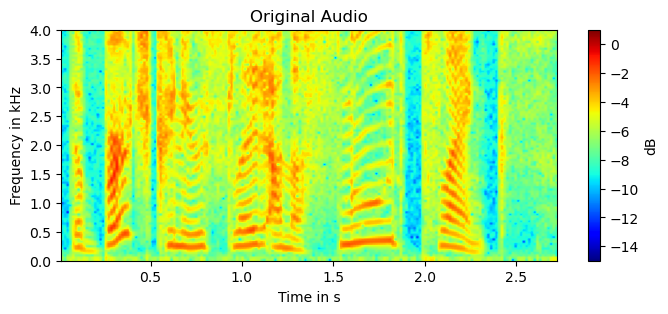

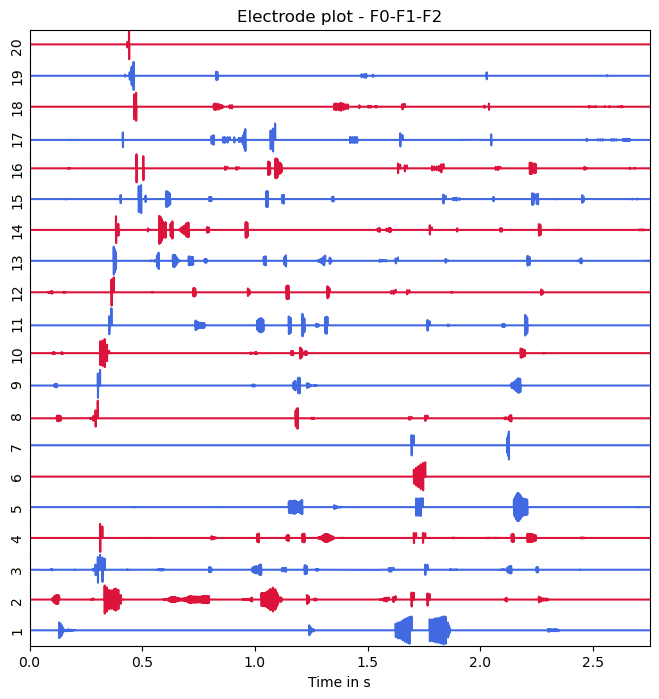

In [32]:
figure(figsize=(8,3))
plot_spectrogram(audio, Fs)
ylim([0,4])
title("Original Audio")

electrodes_concat = [electrode_signal_apical;electrode_signal_basal]
plot_electrode(20,time,electrodes_concat,title="Electrode plot - F0-F1-F2")

electrode_plot_F0F1F2 = electrodes_concat;

---------------------------------------
<hr style="border:2px solid black"> </hr>

## Continuous Interleaved Sampling – CIS

![title](img/CIS.png)

- Digital filter bank with 8 BP
- Rectification, LP filtering - Envelope
- Compression and mapping of amplitude, D/A
- Interleaved, biphasic stimulation, constant rate 833Hz per channel [wilson+1991]

---------------------------------------
<hr style="border:2px solid black"> </hr>

Design of the bandpass filters: chosen to be equally spaced in the Mel-scale

The Mel-scale mimics the human ear perception: 

- higher frequency resolution at lower frequency
- lower frequency resolution at high frequencies

In [33]:
N_channel = 6
low_freq_mel = (2595 * log10(1 + (100) / 700))  # Convert Hz to Mel
high_freq_mel = (2595 * log10(1 + (4000) / 700))  # Convert Hz to Mel
# Equally spaced in Mel scale
mel_points = range(low_freq_mel, high_freq_mel, length = N_channel + 1)  
hz_points = round.( (700 .* (10 .^(mel_points ./ 2595) .- 1)) ); # Mel to Hz

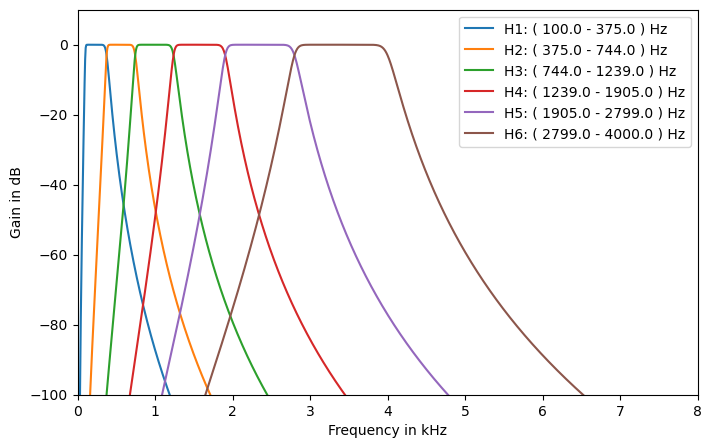

In [34]:
filter_output = zeros(N_channel,length(audio))
w = 0:0.001:pi 

legend_str = Array{Union{Nothing, String}}(nothing, N_channel)

figure(figsize=(8,5))
for i in 1:N_channel
    responsetype = Bandpass(hz_points[i], hz_points[i+1]; fs=Fs);
    prototype = Butterworth(8);
    cochlear_filter = digitalfilter(responsetype, prototype);
    
    H = freqz(cochlear_filter, w)
    plot(Fs/2*w/pi/1000, 20*log10.(abs.(H)))
    xlim([0,8])
    ylim([-100,10])
    xlabel("Frequency in kHz")
    ylabel("Gain in dB")
    filter_output[i,:] = filt(cochlear_filter, audio);
    legend_str[i] = string("H",i,": ","( ",hz_points[i]," - ",
                                                         hz_points[i+1]," ) Hz")
end
legend(legend_str);

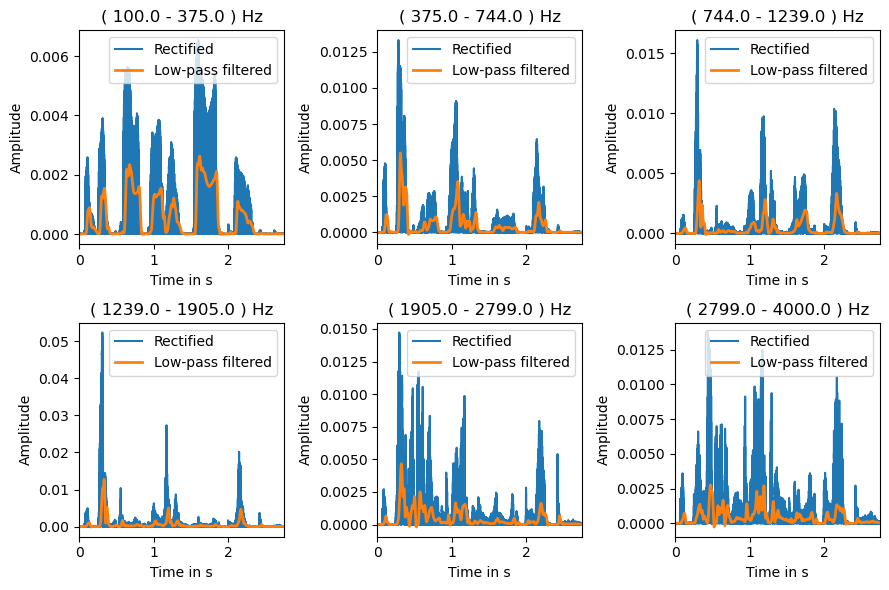

In [35]:
prototype = Butterworth(8);
responsetype = Lowpass(35; fs=Fs);
lp_filter = digitalfilter(responsetype, prototype);

# Rectifier
rect_audio = abs.(filter_output)

# Low pass filter
rect_low = zeros(N_channel,length(audio))
[rect_low[i,:] = filt(lp_filter, rect_audio[i,:]) for i = 1:N_channel]

# Compression
rect_low = atan.(rect_low)*2/pi

figure(figsize=(9,6))
for i = 1:N_channel
    subplot(2,3,i)
    plot_audio(time,rect_audio[i,:])
    plot(time,rect_low[i,:],lw=2)
    legend(["Rectified", "Low-pass filtered"])
    title(string("( ",hz_points[i]," - ",hz_points[i+1]," ) Hz"))
end
tight_layout()

Generate interleaved biphasic pulses at a constant rate of 833 Hz, scaled by the envelope of each BPF output. All electrodes are active at the same time.

In [36]:
N_signal = length(audio)
N_total = N_signal
N_period = convert.( Int, round.( Fs ./ 833 ) )
N_pulse = convert(Int, round(1e-4 * Fs))
N_offset =  convert.( Int, round( (N_period-N_pulse)/N_channel ) )

electrodes = zeros(N_channel,N_signal)

[ electrodes[i,:] = rect_low[i,:].*biphasic_pulse(N_total,N_pulse,N_period, 
                                 offset = N_offset*(i-1)) for i = 1:N_channel ];

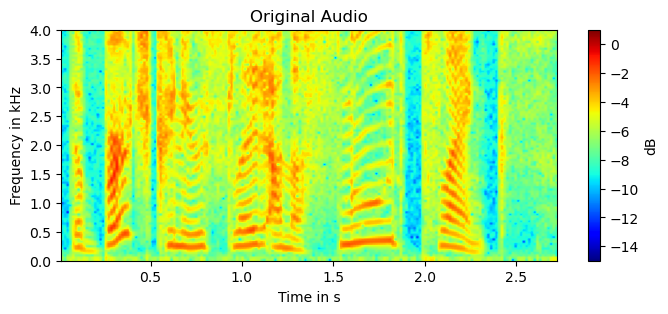

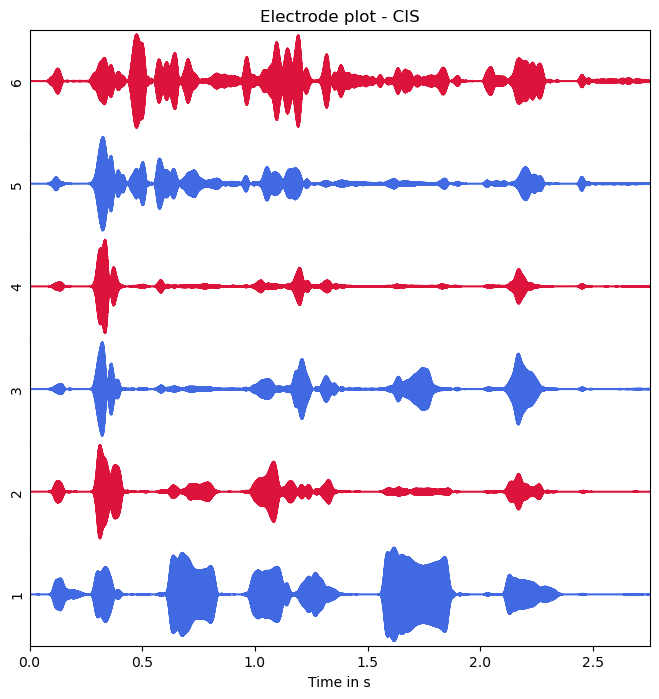

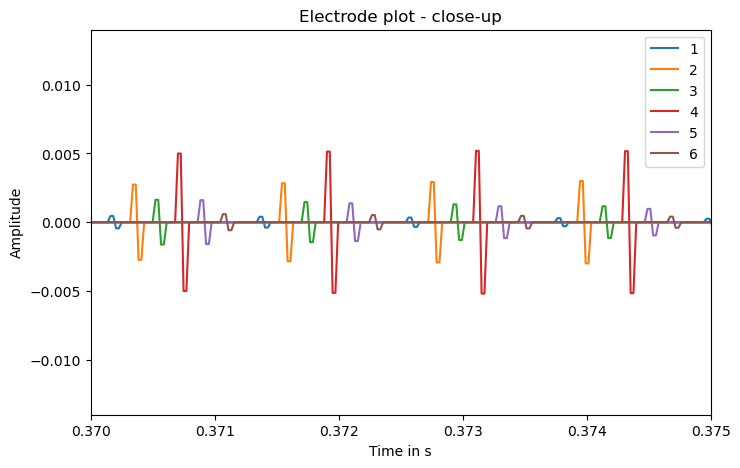

In [37]:
figure(figsize=(8,3))
plot_spectrogram(audio, Fs)
ylim([0,4])
title("Original Audio")

plot_electrode(N_channel,time,electrodes,title="Electrode plot - CIS")

electrode_plot_CIS = electrodes;

figure(figsize=(8,5))
[ plot_audio(time,electrodes[i,:]) for i = 1:N_channel ]
xlim([0.37,0.375])
legend((collect(1:6)))
title("Electrode plot - close-up");

---------------------------------------
<hr style="border:2px solid black"> </hr>

## Spektral PEAK

![title](img/SPEAK.png)

- Filter bank with 20 BPF
- Spectral maximum selection
- Mapping of amplitudes
- Stimulation with adaptive rate (F0)

---------------------------------------
<hr style="border:2px solid black"> </hr>

Design of the bandpass filters: equally spaced in the Mel-scale

In [38]:
N_channel = 20
low_freq_mel = (2595 * log10(1 + (250) / 700))  # Convert Hz to Mel
high_freq_mel = (2595 * log10(1 + (10_000) / 700))  # Convert Hz to Mel
# Equally spaced in Mel scale
mel_points = range(low_freq_mel, high_freq_mel, length = N_channel + 1)  
hz_points = round.( (700 .* (10 .^(mel_points ./ 2595) .- 1)) ); # Mel to Hz

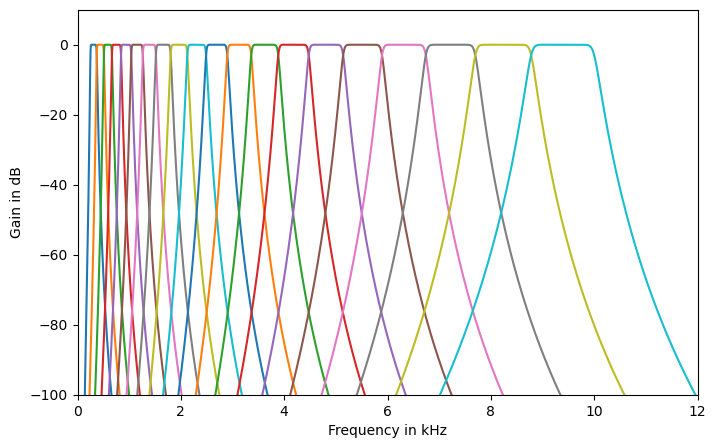

In [39]:
filter_output = zeros(N_channel,length(audio))
w = 0:0.001:pi 

legend_str = Array{Union{Nothing, String}}(nothing, N_channel)
figure(figsize=(8,5))
for i in 1:N_channel
    responsetype = Bandpass(hz_points[i], hz_points[i+1]; fs=Fs);
    prototype = Butterworth(8);
    cochlear_filter = digitalfilter(responsetype, prototype);
    
    H = freqz(cochlear_filter, w)
    plot(Fs/2*w/pi/1000, 20*log10.(abs.(H)))
    xlim([0,12])
    ylim([-100,10])
    xlabel("Frequency in kHz")
    ylabel("Gain in dB")
    filter_output[i,:] = filt(cochlear_filter, audio);
end

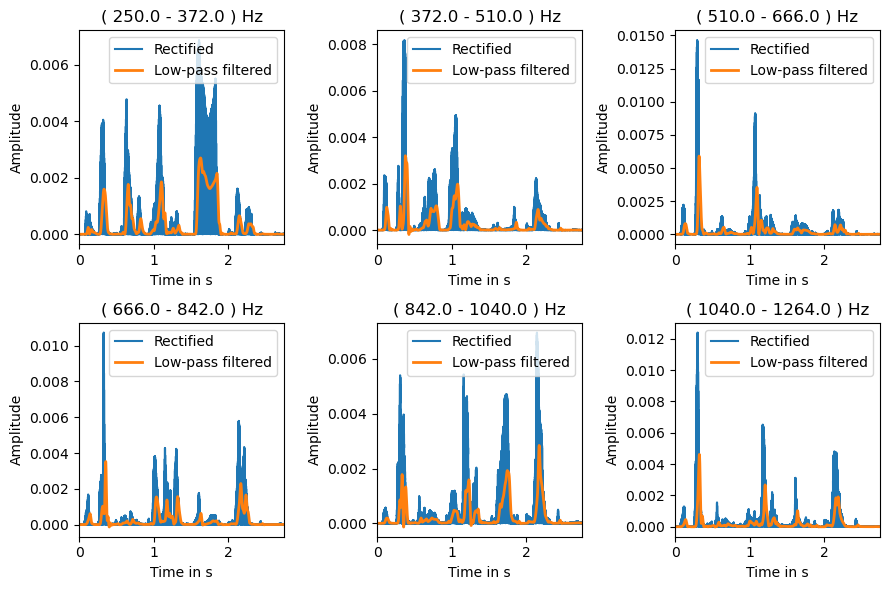

In [40]:
prototype = Butterworth(8);
responsetype = Lowpass(35; fs=Fs);
lp_filter = digitalfilter(responsetype, prototype);

# Rectifier
rect_audio = abs.(filter_output)

# Low pass filter
rect_low = zeros(N_channel,length(audio))
[rect_low[i,:] = filt(lp_filter, rect_audio[i,:]) for i = 1:N_channel]

# Compression
rect_low = atan.(rect_low)*2/pi

figure(figsize=(9,6))
for i = 1:6
    subplot(2,3,i)
    plot_audio(time,rect_audio[i,:])
    plot(time,rect_low[i,:],lw=2)
    legend(["Rectified", "Low-pass filtered"])
    title(string("( ",hz_points[i]," - ",hz_points[i+1]," ) Hz"))
end
tight_layout()

Estimation of the fundamental frequency F0 (coded in pulse rate):

In [41]:
responsetype = Lowpass(270; fs=Fs);
cochlear_filter = digitalfilter(responsetype, prototype);
H_low = freqz(cochlear_filter, w)
filter_output_lowpass = filt(cochlear_filter, audio);

signal_frames_F0 = generate_frames(filter_output_lowpass,Fs);

frame_length = size(signal_frames_F0)[2]
number_frames = size(signal_frames_F0)[1]
time_frames = collect( range(0,last(time),length=number_frames) )

F0_ZC = zeros((number_frames,1))

for (idx,i) in enumerate(1:number_frames)
    F0_ZC[idx] = freq_est_ZC(signal_frames_F0[i,:],Fs)
end

Fixed pulse rate in unvoiced segments:

In [42]:
zcrThreshold = 300
F0_ZC[F0_ZC .> zcrThreshold] .= 100;

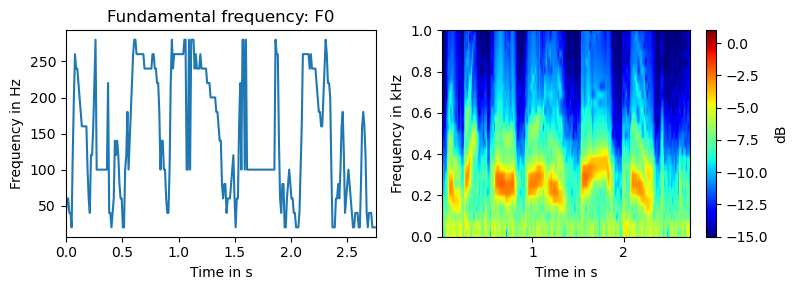

In [43]:
figure(figsize=(8,3))
subplot(1,2,1)
plot_audio(time_frames,F0_ZC)
ylabel("Frequency in Hz")
title("Fundamental frequency: F0")
subplot(1,2,2)
plot_spectrogram(filter_output_lowpass, Fs)
ylim([0,1])
tight_layout()

Generation of interleaved biphasic pulses, where $m$ electrodes are active at the same time (here $m=8$). The $m$ active electrodes are chosen according to the BPF outputs with the highest signal power in the frame. 

In [44]:
N_signal = length(audio)
N_total = convert(Int,ceil(N_signal/number_frames))
N_period_vec = convert.( Int, round.( Fs ./ F0_ZC ) )
N_pulse = convert(Int, 4)
N_offset_vec =  convert.(Int, round.( (N_period_vec .- N_pulse) ./ N_channel ))
N_electrodes = 8;

pulses = []
electrodes = []
frame_power = zeros(N_channel,1)
idx_electrodes = zeros(N_electrodes,1)
electrode_signal = zeros(N_channel,N_signal)

for idx_frame in 1:number_frames
        
    idx_begin = (idx_frame-1)*N_total+1 
    idx_end = min(N_signal,idx_begin+N_total-1)
    idx_diff = idx_end-idx_begin
    
    for i = 1:N_channel
        # signal power
        frame_power[i] = sum(abs.(rect_audio[i,idx_begin : idx_end]).^2)  
    end
    
    idx_electrodes = sortperm(frame_power[:],rev=true)   # sort signal power
    idx_electrodes = idx_electrodes[1:N_electrodes]      # index of active elec.
    
    N_period = N_period_vec[idx_frame]
    N_offset = N_offset_vec[idx_frame]
    
    for i in idx_electrodes
        
        pulse_frame = biphasic_pulse(N_total,N_pulse,N_period,
                                                          offset=N_offset*(i-1))
        pulse_frame = pulse_frame[1:idx_diff+1]
        
        electrode_signal[i,idx_begin : idx_end] = 
                                    rect_audio[i,idx_begin:idx_end].*pulse_frame
        
    end

end

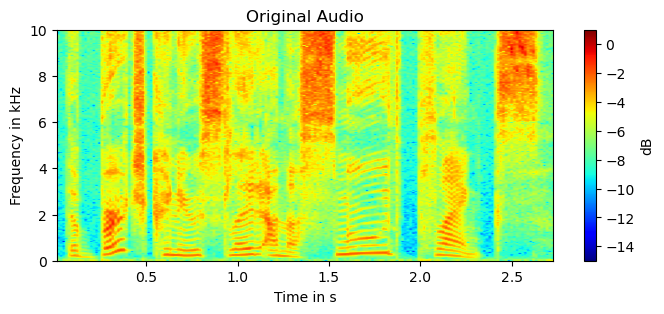

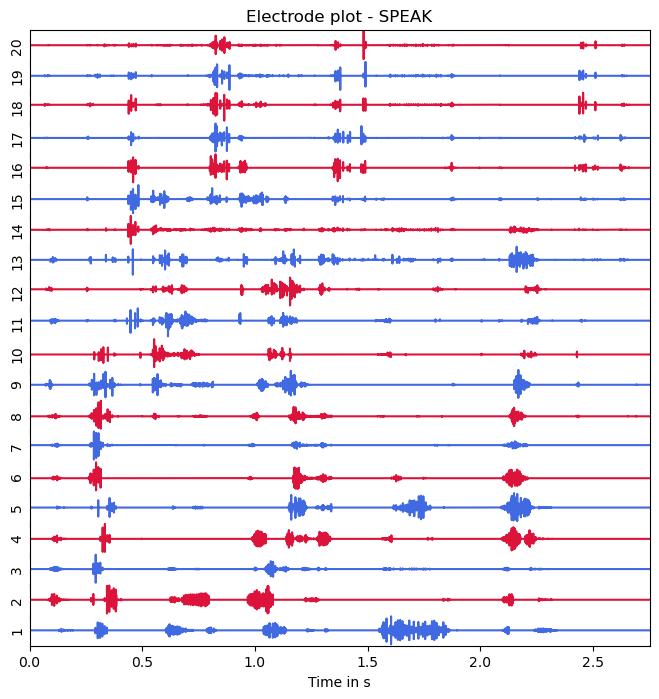

In [45]:
figure(figsize=(8,3))
plot_spectrogram(audio, Fs)
ylim([0,10])
title("Original Audio")

plot_electrode(N_channel,time,electrode_signal,title="Electrode plot - SPEAK")

electrode_plot_SPEAK = electrode_signal;

---------------------------------------
<hr style="border:2px solid black"> </hr>

## Advanced Combination Encoder – ACE

![title](img/SPEAK.png)

- Similar to SPEAK
- Spectral maximum selection
- 8 our of 22 electrodes
- Stimulation with 900 pps

---------------------------------------
<hr style="border:2px solid black"> </hr>

Design of the bandpass filters: equally spaced in the Mel-scale

In [46]:
N_channel = 22
low_freq_mel = (2595 * log10(1 + (250) / 700))  # Convert Hz to Mel
high_freq_mel = (2595 * log10(1 + (10_000) / 700))  # Convert Hz to Mel
# Equally spaced in Mel scale
mel_points = range(low_freq_mel, high_freq_mel, length = N_channel + 1)  
hz_points = round.( (700 .* (10 .^(mel_points ./ 2595) .- 1)) ); # Mel to Hz

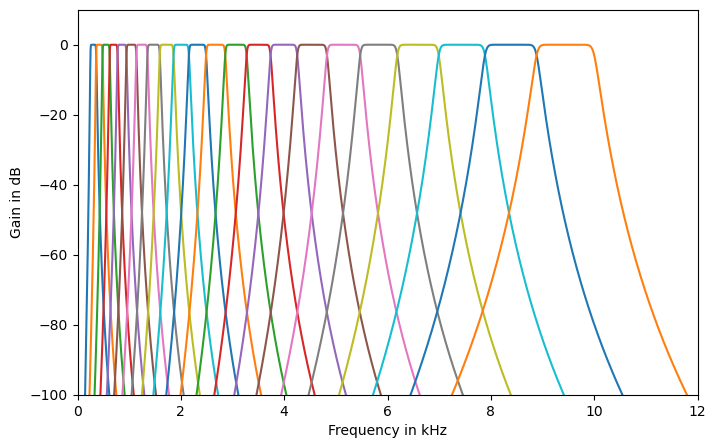

In [47]:
filter_output = zeros(N_channel,length(audio))
w = 0:0.001:pi 

legend_str = Array{Union{Nothing, String}}(nothing, N_channel)
figure(figsize=(8,5))
for i in 1:N_channel
    responsetype = Bandpass(hz_points[i], hz_points[i+1]; fs=Fs);
    prototype = Butterworth(8);
    cochlear_filter = digitalfilter(responsetype, prototype);
    
    H = freqz(cochlear_filter, w)
    plot(Fs/2*w/pi/1000, 20*log10.(abs.(H)))
    xlim([0,12])
    ylim([-100,10])
    xlabel("Frequency in kHz")
    ylabel("Gain in dB")
    filter_output[i,:] = filt(cochlear_filter, audio);
end

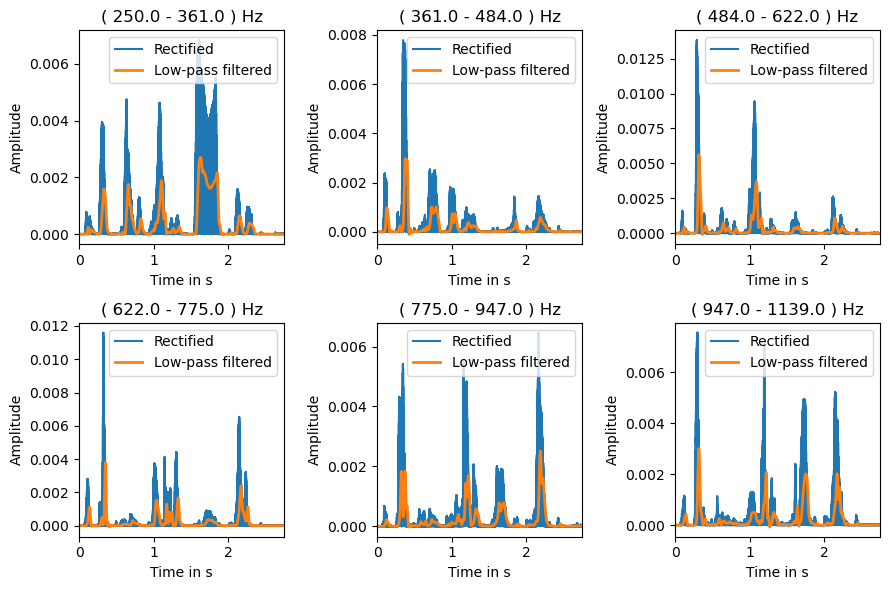

In [48]:
prototype = Butterworth(8);
responsetype = Lowpass(35; fs=Fs);
lp_filter = digitalfilter(responsetype, prototype);

# Rectifier
rect_audio = abs.(filter_output)

# Low pass filter
rect_low = zeros(N_channel,length(audio))
[rect_low[i,:] = filt(lp_filter, rect_audio[i,:]) for i = 1:N_channel]

# Compression
rect_low = atan.(rect_low)*2/pi

figure(figsize=(9,6))
for i = 1:6
    subplot(2,3,i)
    plot_audio(time,rect_audio[i,:])
    plot(time,rect_low[i,:],lw=2)
    legend(["Rectified", "Low-pass filtered"])
    title(string("( ",hz_points[i]," - ",hz_points[i+1]," ) Hz"))
end
tight_layout()

Fixed pulse rate of 900 pps.

In [49]:
N_signal = length(audio)
N_total = convert(Int,ceil(N_signal/number_frames))
N_period = convert.( Int, round.( Fs ./ 900 ) ) 
N_pulse = convert(Int, 4)
N_offset =  convert.( Int, round.( (N_period .- N_pulse) ./ N_channel ) )
N_electrodes = 8;

Generate interleaved biphasic pulses with fixed pulse rate, where 8 of 22 electrodes are active simultaneously.

In [50]:
pulses = []
electrodes = []
frame_power = zeros(N_channel,1)
idx_electrodes = zeros(N_electrodes,1)
electrode_signal = zeros(N_channel,N_signal)

for idx_frame in 1:number_frames
        
    idx_begin = (idx_frame-1)*N_total+1 
    idx_end = min(N_signal,idx_begin+N_total-1)
    idx_diff = idx_end-idx_begin
    
    for i = 1:N_channel
        frame_power[i] = sum(abs.(rect_audio[i,idx_begin : idx_end]).^2)
    end
    
    idx_electrodes = sortperm(frame_power[:],rev=true)
    idx_electrodes = idx_electrodes[1:N_electrodes]
        
    for i in idx_electrodes
        
        pulse_frame = biphasic_pulse(N_total,N_pulse,N_period,
                                                          offset=N_offset*(i-1))
        pulse_frame = pulse_frame[1:idx_diff+1]
        
        electrode_signal[i,idx_begin : idx_end] = 
                                    rect_audio[i,idx_begin:idx_end].*pulse_frame
        
    end

end

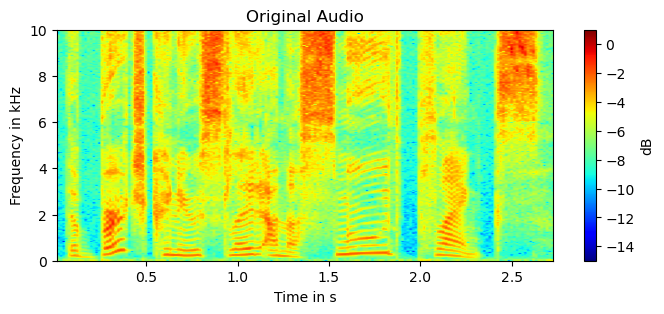

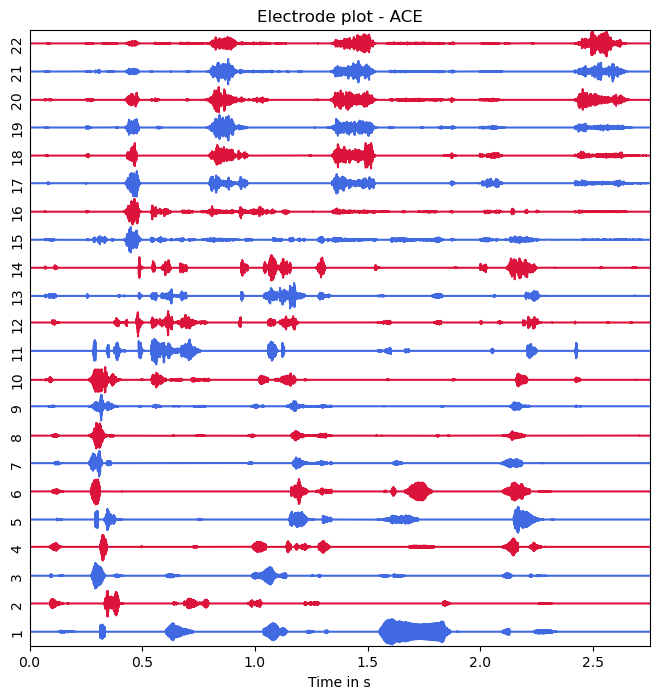

In [51]:
figure(figsize=(8,3))
plot_spectrogram(audio, Fs)
ylim([0,10])
title("Original Audio")

plot_electrode(N_channel,time,electrode_signal,title="Electrode plot - ACE")

electrode_plot_ACE = electrode_signal;

---------------------------------------
<hr style="border:2px solid black"> </hr>

## Fine Structure Processing (FSP)

Nowadays, a popular coding strategy is CIS, where the information of the audio signal is coded in the envelope of interleaved pulse trains with equal pulse rate. This concept was further developed by MED-EL by introducing Fine Structure Processing (FSP).
![title](img/FSP_intro.png)

As seen in earlier coding strategies, information about the frequency of an audio signal is coded in the spatial distribution of active auditorial nerves in the cochlear - also known as *tonotopic* (spatial) coding. 

A second method how frequency is coded in the cochlear is *phase locking* (temporal coding) as shown in the picture above. For lower frequencies (20Hz up to 1-2 kHz), the auditory nerves can fire fast enough to react to every period of the audio signal. The pulse rate is equal to the fundamental frequency of the audio signal. For lower frequencies, the temporal coding of frequency in the pulse rate is even more relevant than the spatial coding and thus can greatly improve speech perception.

For higher frequencies, the auditory nerves cannot react fast enough - there only the spatial coding is used to determine frequency. Here, a constant pulse rate is used to stimulate the electrodes.


![title](img/FSP.png)

- Low frequency neural response phase locked with audio:
  - Lower frequencies: Pulse rate determined from zero-crossing rate of BPF output
  - Higher frequencies: Pulse rate with fixed value (here 1000 pps)

---------------------------------------
<hr style="border:2px solid black"> </hr>

Design of the bandpass filters: equally spaced in the Mel-scale

In [52]:
N_channel = 12
low_freq_mel = (2595 * log10(1 + (50) / 700))  # Convert Hz to Mel
high_freq_mel = (2595 * log10(1 + (10_000) / 700))  # Convert Hz to Mel
# Equally spaced in Mel scale
mel_points = range(low_freq_mel, high_freq_mel, length = N_channel + 1)  
hz_points = round.( (700 .* (10 .^(mel_points ./ 2595) .- 1)) ); # Mel to Hz

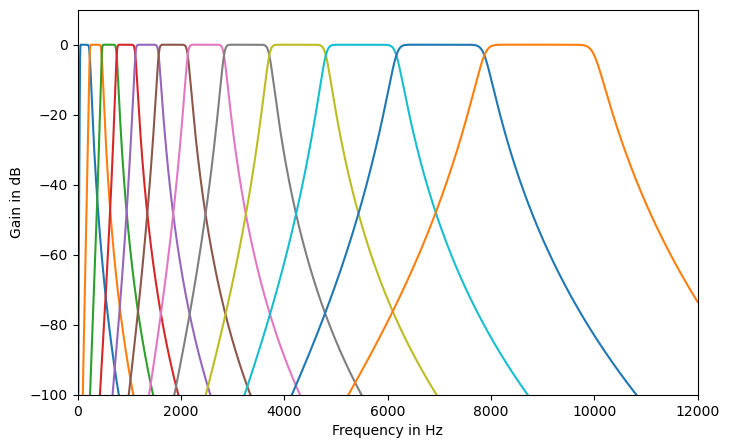

In [53]:
filter_output = zeros(N_channel,length(audio))
w = 0:0.001:pi 

legend_str = Array{Union{Nothing, String}}(nothing, N_channel)
figure(figsize=(8,5))
for i in 1:N_channel
    responsetype = Bandpass(hz_points[i], hz_points[i+1]; fs=Fs);
    prototype = Butterworth(8);
    cochlear_filter = digitalfilter(responsetype, prototype);
    
    H = freqz(cochlear_filter, w)
    plot(Fs/2*w/pi, 20*log10.(abs.(H)))
    xlim([0,12e3])
    ylim([-100,10])
    xlabel("Frequency in Hz")
    ylabel("Gain in dB")
    filter_output[i,:] = filt(cochlear_filter, audio);
end

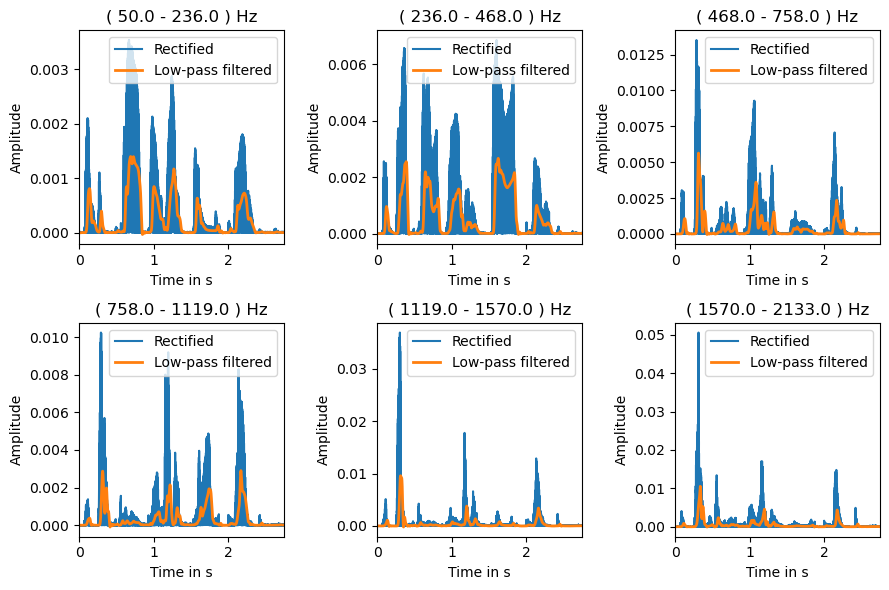

In [54]:
prototype = Butterworth(8);
responsetype = Lowpass(35; fs=Fs);
lp_filter = digitalfilter(responsetype, prototype);

# Rectifier
rect_audio = abs.(filter_output)

# Low pass filter
rect_low = zeros(N_channel,length(audio))
[rect_low[i,:] = filt(lp_filter, rect_audio[i,:]) for i = 1:N_channel]

# Compression
rect_low = atan.(rect_low)*2/pi

figure(figsize=(9,6))
for i = 1:6
    subplot(2,3,i)
    plot_audio(time,rect_audio[i,:])
    plot(time,rect_low[i,:],lw=2)
    legend(["Rectified", "Low-pass filtered"])
    title(string("( ",hz_points[i]," - ",hz_points[i+1]," ) Hz"))
end
tight_layout()

Zero-crossing rate for lower frequency filter outputs (here < 1000 Hz):

In [55]:
temp = generate_frames(audio,Fs);
frame_length = size(temp)[2]
number_frames = size(temp)[1]
time_frames = collect( range(0,last(time),length=number_frames) )

N_FSP = length(hz_points[hz_points .< 1000])-1
signal_frames = zeros(N_FSP,number_frames,frame_length);

for i = 1:N_FSP
    signal_frames[i,:,:] = generate_frames(filter_output[i,:],Fs);
end

In [56]:
F_ZC = zeros((N_FSP,number_frames))

for idx_channel = 1:N_FSP
    for idx = 1:number_frames
        F_ZC[idx_channel,idx] = freq_est_ZC(signal_frames[idx_channel,idx,:],Fs)
    end
end

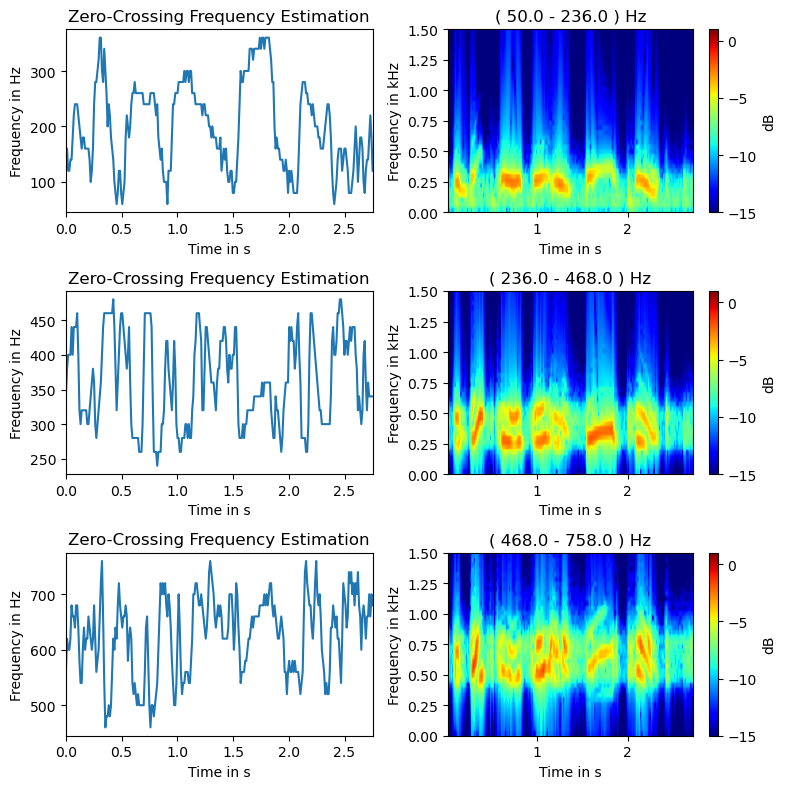

In [57]:
figure(figsize=(8,8))
for i = 1:N_FSP
    subplot(N_FSP,2,(i-1)*2+1)
    plot_audio(time_frames,F_ZC[i,:])
    ylabel("Frequency in Hz")
    title("Zero-Crossing Frequency Estimation")
    subplot(N_FSP,2,i*2)
    plot_spectrogram(filter_output[i,:], Fs)
    ylim([0,1.5])
    title(string("( ",hz_points[i]," - ",hz_points[i+1]," ) Hz"))
end
tight_layout()

Generate the electrode signals:

- Lower frequencies: Pulse rate determined from zero-crossing rate of BPF output
- Higher frequencies: Pulse rate with fixed rate (here 1000 pps)

In [58]:
N_signal = length(audio)
N_total = convert(Int,ceil(N_signal/number_frames))

N_period_vec = convert.( Int, round.( Fs ./ F_ZC ) )
N_pulse = convert(Int, 2)

N_period_max = convert.( Int, round.( Fs ./ 1000 ) )
N_offset =  convert( Int, round( (N_period_max - N_pulse) / N_channel ) )
N_electrodes = 8;

In [59]:
pulses = []
electrodes = []
frame_power = zeros(N_channel,1)
idx_electrodes = zeros(N_electrodes,1)
electrode_signal = zeros(N_channel,N_signal)

for idx_frame in 1:number_frames
        
    idx_begin = (idx_frame-1)*N_total+1 
    idx_end = min(N_signal,idx_begin+N_total-1)
    idx_diff = idx_end-idx_begin
    
    for i = 1:N_channel
        frame_power[i] = sum(abs.(rect_audio[i,idx_begin : idx_end]).^2)
    end
    
    idx_electrodes = sortperm(frame_power[:],rev=true)
    idx_electrodes = idx_electrodes[1:N_electrodes]
    
    for i in idx_electrodes
        
        if i <= N_FSP
            N_period = N_period_vec[i,idx_frame]
        else 
            N_period = convert.( Int, round.( Fs ./ 1000 ) )
        end
        
        pulse_frame = biphasic_pulse(N_total,N_pulse,N_period,
                                                          offset=N_offset*(i-1))
        pulse_frame = pulse_frame[1:idx_diff+1]  
        electrode_signal[i,idx_begin : idx_end] = 
                                    rect_audio[i,idx_begin:idx_end].*pulse_frame
        
    end

end

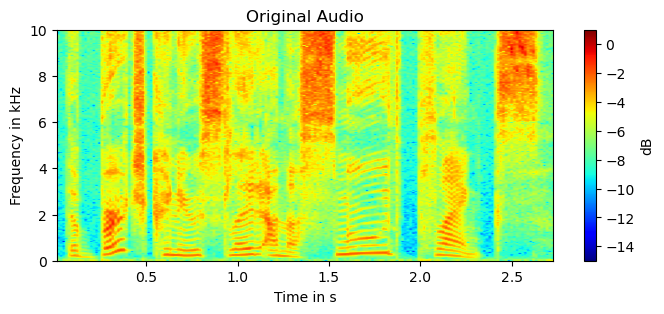

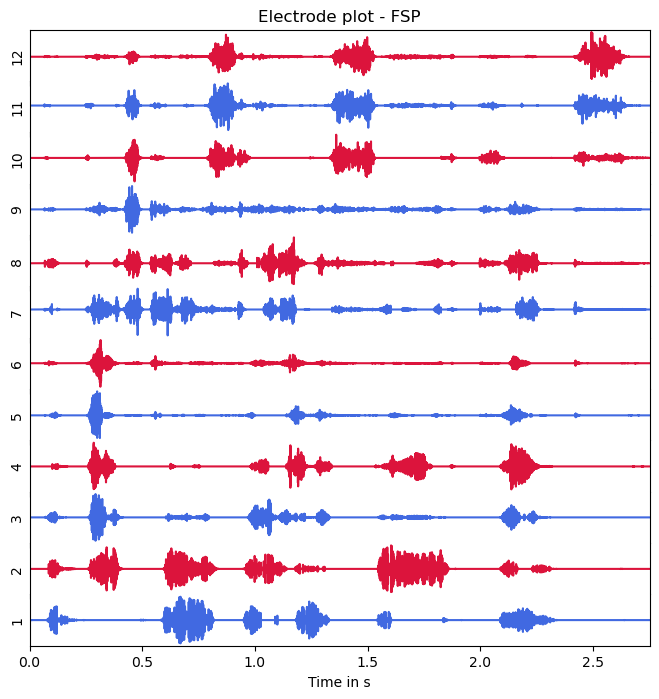

In [60]:
figure(figsize=(8,3))
plot_spectrogram(audio, Fs)
ylim([0,10])
title("Original Audio")

plot_electrode(N_channel,time,electrode_signal,title="Electrode plot - FSP")

electrode_plot_FSP = electrode_signal;

-------------------------------

## Comparison of all coding strategies 

-------------------------------

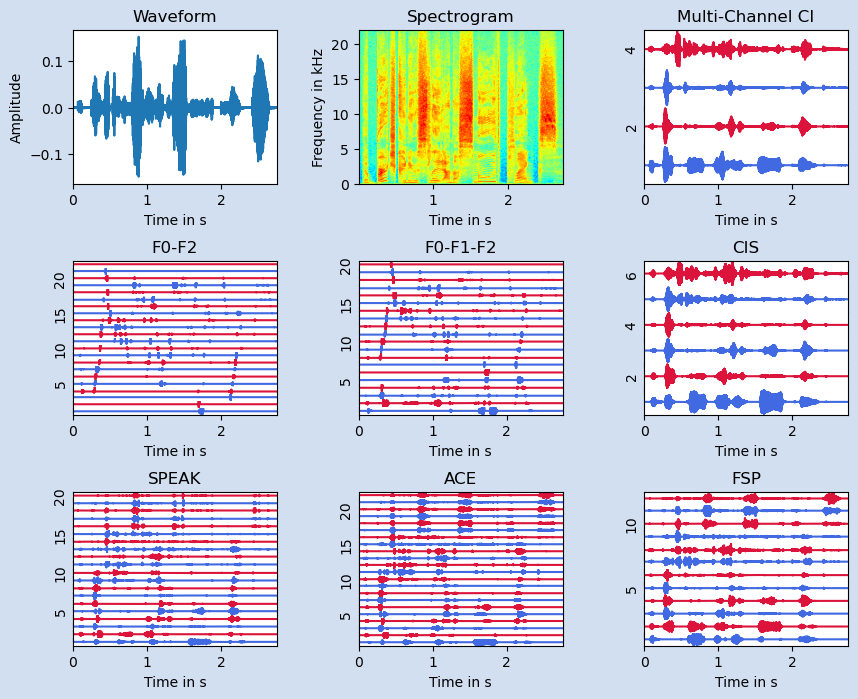

In [61]:
fig = figure(figsize=(10, 8),facecolor=(209,223,241)./255)

gs0 = gridspec.GridSpec(3,3)
gs0.update(wspace=0.4, hspace=0.5)

N_subplots = [1,1,4,22,20,6,20,22,12]
N_yticks = [2,5,5,2,5,5,5]
plot_vec = [electrode_plot_MCCI,electrode_plot_F0F2,electrode_plot_F0F1F2,
  electrode_plot_CIS,electrode_plot_SPEAK,electrode_plot_ACE,electrode_plot_FSP]
title_vec = ["Multi-Channel CI","F0-F2","F0-F1-F2","CIS","SPEAK","ACE","FSP"]
gs = [gridspec.GridSpecFromSubplotSpec(N_subplots[i], 1, subplot_spec=gs0[i])
    for i = 1:9];
ax = [ [ fig.add_subplot(gs[i][j,1]) for j = 1:N_subplots[i]] for i = 1:9 ]

plot_audio_subplot(time,audio,ax[1][1],title="Waveform")
plot_spectrogram_subplot(audio, Fs, ax[2][1],title="Spectrogram")
[plot_electrode_subplot(N_subplots[i],time,plot_vec[i-2],ax[i],
                      title=title_vec[i-2],N_yticks=N_yticks[i-2]) for i = 3:9];
